In [23]:
import os
import netCDF4
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import logging
import pycountry
import calendar
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
from matplotlib import colorbar
from matplotlib import cm
from matplotlib import colors
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [129]:
logger = logging.getLogger("TemperatureCountry")
logger.setLevel(logging.WARNING)
logging.info("Start")

In [17]:
datafile = "/data/LandTemperature/Europe_TAVG_LatLong0.25.nc"
shapedir = "/data/ShapeFiles/"
country_shape_file = os.path.join(shapedir, "ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp")

## Read data
### Shape file

In [4]:
r = shapefile.Reader(country_shape_file)
shapes = r.shapes()
records = r.records()

### Temperature product

In [111]:
with netCDF4.Dataset(datafile) as nc:
    lon = nc.get_variables_by_attributes(standard_name="longitude")[0][:]
    lat = nc.get_variables_by_attributes(standard_name="latitude")[0][:]
    time = nc.get_variables_by_attributes(standard_name="time")[0][:]
    clim = nc.variables["climatology"][:]
    temperature = nc.variables["temperature"][:]

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


Compute anomalies

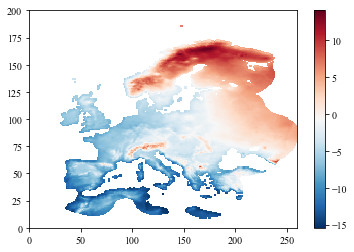

In [32]:
anom = temperature[0,:,:] - clim[0,:,:]
plt.pcolormesh(anom, cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.show()
plt.close()

In [7]:
def get_coords_land(lon, lat, field, NN=20):
    """
    Return the coordinates and the indices of the grid points
    corresponding to land
    """
    coordlist = []
    indexlist = []
    for i in range(0, len(lon), NN):
        for j in range(0, len(lat), NN):
            # Check if value is not masked
            if not(np.ma.is_masked(field[j, i])):
                coordlist.append((lat[j], lon[i]))
                indexlist.append((j,i))
    return coordlist, indexlist

Find the country for all the points in the list of coordinates

In [9]:
coordlist0, indexlist0 = get_coords_land(lon, lat, clim[0,:,:], NN=1)
locations = rg.search(coordlist0)

Create a dictionary in which keys are countries and values are a list of indices.

In [10]:
countrydict = dict()
for locs, index in zip(locations, indexlist0):
    countrycode = locs["cc"]
    if countrycode in countrydict.keys():
        logger.debug("Already in the list")
        countrydict[countrycode].append(index)
    else:
        logger.debug("Not yet in the list")
        countrydict[countrycode] = [index]

In [130]:
m = Basemap(projection='merc',llcrnrlat=33,urcrnrlat=65,
            llcrnrlon=-10,urcrnrlon=50,resolution='i')

### Compute average on country

In [110]:
# Loop on the countries
for countrycode, indices in countrydict.items():
    try:
        country = pycountry.countries.get(alpha_2=countrycode)
        countryname = country.name
    except KeyError:
        if countrycode == "XK":
            countryname = "Kosovo"
        else:
            logger.warning("Unknown country code {}".format(countrycode))

    row, col = [], []
    for ind in indices:
        row.append(ind[0])
        col.append(ind[1])
    fieldmean = np.mean(clim0[row, col])
    logger.debug("Field mean for {}: {}".format(country.name, fieldmean))

In [134]:
cmap = matplotlib.cm.get_cmap('RdBu_r')
norm = matplotlib.colors.Normalize(vmin=-15.0, vmax=15.0)

In [135]:
def choropleth_anom(anomalies, figtitle, figname):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)
    m.ax = ax
    plt.title(figtitle, fontsize=20)

    for record, shape in zip(records, shapes):
        # Take only European countries
        if record[-12] == "Europe":
            countryname = record[3]
            countrycode = record[45]

            if countrycode == "-99":
                # Try inverse mapping
                country = pycountry.countries.get(name=countryname)
                countrycode = country.alpha_2

            logger.debug(countrycode)
            # Convert country name to code
            # Get the mean value for that country
            row, col = [], []

            try: 
                indexlist = countrydict[countrycode]

                for ind in indexlist:
                    row.append(ind[0])
                    col.append(ind[1])
                anommean = np.mean(anomalies[row, col])

                # Deduce the color
                countrycolor = cmap(norm(anommean))
            except KeyError:
                countrycolor = "w"
                logger.info("Country {} not found in initial list".format(countrycode))
                logger.info(record[3])
            # Read coordinates
            logger.debug("Working on  {}".format(countryname))
            lons, lats = zip(*shape.points)
            data = np.array(m(lons, lats)).T

            if len(shape.parts) == 1:
                segs = [data, ]
            else:
                segs = []
                for i in range(1, len(shape.parts)):
                    index = shape.parts[i-1]
                    index2 = shape.parts[i]
                    segs.append(data[index:index2])
                segs.append(data[index2:])

            lines = LineCollection(segs, antialiaseds=(1,))
            lines.set_facecolors(countrycolor)
            lines.set_edgecolors('k')
            lines.set_linewidth(0.1)
            ax.add_collection(lines)

    cax = fig.add_axes([0.9, 0.15, 0.035, 0.8])
    cmap.set_over((0., 0., 0.))
    cb1 = colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm, extend="both",
                                orientation='vertical', spacing='uniform')
    cb1.ax.tick_params(labelsize=14)
    cb1.outline.set_edgecolor('white')

    m.drawcoastlines(linewidth=.25, color=".75")
    # Remove frame
    ax.axis('off')
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()

## Plots
### One color per country

In [42]:
color=iter(plt.cm.rainbow(np.linspace(0,1,len(countrydict))))
fig = plt.figure(figsize=(10, 10))
for k, v in countrydict.items():
    c=next(color)
    for coords in v:
        plt.plot(lon[coords[1]], lat[coords[0]], 'o', ms=.5, color=c)
plt.savefig("clim_country00.png", dpi=300, bbox_inches="tight")
plt.close()

In [80]:
replaceDict = {"Russia": "Russian Federation"}
for k, v in replaceDict.items():
    if k in countrydict.keys():
        print(k)

## Loop on time

In [ ]:
for i in range(0, len(time)):
    anom = temperature[i,:,:] - clim[np.mod(i, 12)]
    year = np.floor(time[i])
    month = calendar.month_name[np.mod(i, 12) + 1]
    figtitle = " ".join((month, str(int(year))))
    figname = "temp_anomalies_{}".format(str(i).zfill(3))
    choropleth_anom(anom, figtitle, figname)